## 1. Import libraries and load the dataset 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pmdarima as pmd
from statsmodels.tsa.api import DynamicFactorMQ
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [14]:
# Load the dataset
df = pd.read_csv("./ETH.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Change %'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
                                    
# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df['Vol.'] = df['Vol.'].str.replace('K', 'e3')
df['Vol.'] = df['Vol.'].str.replace('M', 'e6')
df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
df

,Price,Vol.
Date,,
2017-12-01,460.67,594100.0
2017-12-02,455.51,473670.0
2017-12-03,459.49,482910.0
2017-12-04,465.00,431180.0
2017-12-05,451.87,656340.0
...,...,...
2023-06-12,1742.60,320470.0
2023-06-13,1739.60,303230.0
2023-06-14,1650.96,451130.0


## 2. Split the data into training, test and validate sets

In [15]:
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1214, 2)
Test shape: (607, 2)
Validate shape: (203, 2)


In [16]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1416, 2)
Test shape: (404, 2)
Validate shape: (204, 2)


In [17]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1214, 2)
Test shape: (404, 2)
Validate shape: (406, 2)


## 3. Perform Dynamic Factor Model

### 3.1 Build and fit train data into Dynamic Factor Model

In [18]:
features = ['Price']
df_model = DynamicFactorMQ(endog=train_data, factors=2, factor_orders=1, idiosyncratic_ar1=True)
df_model_fit = df_model.fit(maxiter=100, disp=True)
df_model_fit.summary()

EM start iterations, llf=-3151.5
EM iteration 2, llf=-1338.3, convergence criterion=0.80772
EM iteration 3, llf=-1338.3, convergence criterion=2.6308e-07
EM converged at iteration 3, llf=-1338.3, convergence criterion=2.6308e-07 < tolerance=1e-06


C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Dynamic Factor Results                              
===================================================================================
Dep. Variable:           ['Price', 'Vol.']   No. Observations:                 1214
Model:                Dynamic Factor Model   Log Likelihood               -1338.281
                   + 2 factors in 2 blocks   AIC                           2700.562
                     + AR(1) idiosyncratic   BIC                           2761.782
Date:                     Fri, 16 Jun 2023   HQIC                          2723.610
Time:                             23:33:52   EM Iterations                        3
Sample:                         12-01-2017                                         
                              - 03-28-2021                                         
Covariance Type:              Not computed                                         
                          Observation equation:                           
==========================================================================
Factor loadings:          0          1    idiosyncratic: AR(1)        var.
--------------------------------------------------------------------------
           Price      -0.71       0.39                   -0.00        0.00
            Vol.       0.71       0.39                   -0.00        0.00
       Transition: Factor block 0      
=======================================
                 L1.0    error variance
---------------------------------------
         0       0.93              0.18
       Transition: Factor block 1      
=======================================
                 L1.1    error variance
---------------------------------------
         1       0.85              0.57
=======================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [19]:
def evaluate_dynamic_factor_model(data):
    pred = df_model_fit.predict(start=data.index[0], end=data.index[len(data)-1])
    data = data[features]
    pred = pred[features]
    mse = mean_squared_error(data, pred)
    mae = mean_absolute_error(data, pred)
    mape = mean_absolute_percentage_error(data, pred)
    rmse = mean_squared_error(data, pred, squared=False)
    return pred, mse, mae, mape, rmse

### 3.2 Evaluate on Validate data

In [20]:
y_pred_val, val_mse, val_mae, val_mape, val_rmse = evaluate_dynamic_factor_model(val_data)

print("Price predict on validate data:", y_pred_val)

Price predict on validate data:                  Price
2022-05-07  417.153402
2022-05-08  417.153402
2022-05-09  417.153402
2022-05-10  417.153402
2022-05-11  417.153402
...                ...
2023-06-12  417.153402
2023-06-13  417.153402
2023-06-14  417.153402
2023-06-15  417.153402
2023-06-16  417.153402

[406 rows x 1 columns]


### 3.3 Evaluate on Test data

In [21]:
y_pred_test, test_mse, test_mae, test_mape, test_rmse = evaluate_dynamic_factor_model(test_data)
print("Price predict on test data:", y_pred_test)

Price predict on test data:                   Price
2021-03-29  1563.223122
2021-03-30  1453.933388
2021-03-31  1357.044529
2021-04-01  1270.943391
2021-04-02  1194.244691
...                 ...
2022-05-02   417.153402
2022-05-03   417.153402
2022-05-04   417.153402
2022-05-05   417.153402
2022-05-06   417.153402

[404 rows x 1 columns]


### 3.4 Predict price for the next 30 days

In [22]:
last_index = len(df)

date_range = pd.date_range(start=df.index[-1], periods=30, freq='D')

y_next_30_days = df_model_fit.predict(start=date_range[0], end=date_range[len(date_range)-1])[features]

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
                 Price
2023-06-16  417.153402
2023-06-17  417.153402
2023-06-18  417.153402
2023-06-19  417.153402
2023-06-20  417.153402
2023-06-21  417.153402
2023-06-22  417.153402
2023-06-23  417.153402
2023-06-24  417.153402
2023-06-25  417.153402
2023-06-26  417.153402
2023-06-27  417.153402
2023-06-28  417.153402
2023-06-29  417.153402
2023-06-30  417.153402
2023-07-01  417.153402
2023-07-02  417.153402
2023-07-03  417.153402
2023-07-04  417.153402
2023-07-05  417.153402
2023-07-06  417.153402
2023-07-07  417.153402
2023-07-08  417.153402
2023-07-09  417.153402
2023-07-10  417.153402
2023-07-11  417.153402
2023-07-12  417.153402
2023-07-13  417.153402
2023-07-14  417.153402
2023-07-15  417.153402


### 4.  Evaluate accuracy validate, test data

In [23]:
metrics = {
    'MSE': [val_mse, test_mse],
    'MAE': [val_mae, test_mae],
    'MAPE': [val_mape, test_mape],
    'RMSE': [val_rmse, test_rmse],
}

acc = pd.DataFrame(metrics, index=['Validate', 'Test'])

print(acc)

                   MSE          MAE      MAPE         RMSE
Validate  1.411198e+06  1153.292337  0.725187  1187.938656
Test      7.648738e+06  2653.167910  0.841626  2765.635102


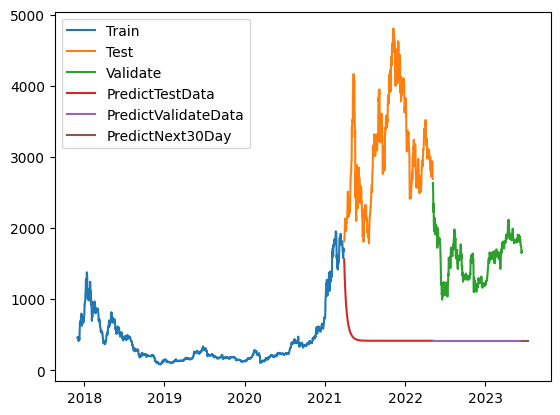

In [24]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])

plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(date_range, y_next_30_days)

plt.legend(['Train', 'Test', 'Validate','PredictTestData', 'PredictValidateData','PredictNext30Day'])
plt.show()